In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
#import hurst 
#from hurst import compute_Hc, random_walk
from itertools import combinations
import json
import requests
import time
import warnings
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
warnings.filterwarnings('ignore')

In [2]:
from sklearnex import patch_sklearn
patch_sklearn()
#Speeding up the computation

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [293]:
da_1=pd.DataFrame()
st = datetime.datetime(2021, 5, 15 , 0, 0)
en = datetime.datetime(2022, 6, 3, 0, 0)
coin=['BTC','UNI','SUSHI','CRV','SOL','MANA','COMP','DOGE','BAT','MATIC','ENJ','XMR','LINK','BCH','XLM','ADA','BNB','LTC','ETH']
#encoding= 'latin-1'
#coin=['ETH','MATIC']
j=1
for i in tqdm(coin):
    da=pd.read_pickle('C:\\Users\\91626\\Work\\project\\Quant Res\\Stat Arbitrage\\'+str(i)+'.pkl')
    da=da[st:en]
    da_1[i]=(da.groupby(pd.Grouper(freq='5Min')).agg({"open": "first","close": "last","low": "min","high": "max"})['close'])

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:02<00:00,  7.11it/s]


In [372]:
da_1.fillna(method='bfill',inplace=True)

In [297]:
st = datetime.datetime(2021, 5, 15 , 0, 0)
en_mid = datetime.datetime(2022, 1, 3, 0, 0)
da1= da_1[st:en_mid]

In [298]:
#Calculate average annual percentage return and volatilities
returns = pd.DataFrame(da1.pct_change().mean() * 252*12*24)
#print(returns)
returns.columns = ['Returns']
returns['Volatility'] = da1.pct_change().std() * np.sqrt(252*12*24)
data=returns
data

,Returns,Volatility
BTC,0.214439,0.744450
UNI,-0.136912,1.203723
SUSHI,0.197192,1.414620
CRV,1.681345,1.514657
SOL,2.593672,1.457858
MANA,2.277921,1.585379
COMP,-0.687499,1.207874
DOGE,-0.354496,1.343001
BAT,0.868177,1.268085
MATIC,1.963510,1.680681


In [299]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(data)
rescaledDataset = pd.DataFrame(scaler.fit_transform(data),columns = data.columns, index = data.index)
X=rescaledDataset
X.head(2)


,Returns,Volatility
BTC,-0.329012,-2.224939
UNI,-0.693517,-0.221602


In [300]:
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold


## K-Means

In [301]:
from sklearn.cluster import KMeans
inertia=[]
seed=42

for k in tqdm(range(2,16)):#max loop=16
    kmeans= KMeans(n_clusters=k,random_state=seed,n_jobs=-1,verbose=True)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    #print(inertia[-1])

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 80.31it/s]

Initialization complete
Iteration 0, inertia 10.951519789123155.
Initialization complete
Iteration 1, inertia 10.951519789123155.
Initialization complete
Iteration 2, inertia 10.951519789123155.
Initialization complete
Iteration 3, inertia 10.951519789123155.
Initialization complete
Iteration 4, inertia 10.951519789123155.
Initialization complete
Iteration 5, inertia 10.951519789123155.
Initialization complete
Iteration 6, inertia 10.951519789123155.
Initialization complete
Iteration 7, inertia 10.951519789123155.
Initialization complete
Iteration 8, inertia 10.951519789123155.
Initialization complete
Iteration 9, inertia 10.951519789123155.
Initialization complete
Iteration 0, inertia 6.176307685464961.
Initialization complete
Iteration 1, inertia 6.659119956538463.
Initialization complete
Iteration 2, inertia 6.176307685464961.
Initialization complete
Iteration 3, inertia 6.176307685464961.
Initialization complete
Iteration 4, inertia 6.659119956538463.
Initialization complete
Iterat

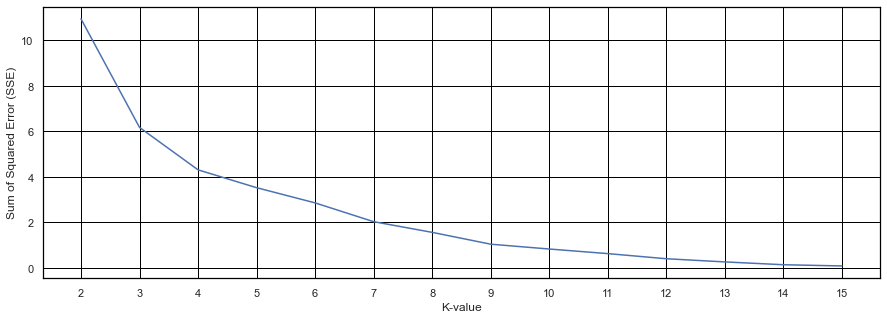

In [302]:
#Elbow method
plt.figure(figsize=(15, 5))
sns.set(rc={'axes.facecolor':'white','axes.edgecolor':'black'})
plt.plot(range(2, 16),inertia)
plt.xticks([i for i in range(2, 16)])
plt.xlabel('K-value')
plt.ylabel('Sum of Squared Error (SSE)')
plt.grid(True,color='black')

#Range of k-value = {6,7,8}

In [303]:
#Silhouette Score Method
from sklearn import metrics

silhouette_score = []
for k in tqdm(range(2,19)):  #Max 19 cant exceed n_samples-1 (19 coins)
    
    kmeans= KMeans(n_clusters=k,random_state=seed,n_jobs=-1)
    kmeans.fit(X)
    silhouette= metrics.silhouette_score(X, kmeans.labels_,random_state=10)
    silhouette_score.append(silhouette)
    #print(silhouette)

100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 193.72it/s]


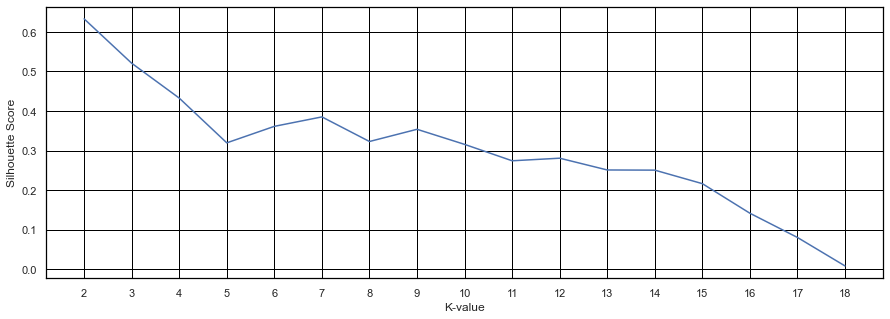

In [304]:
plt.figure(figsize=(15, 5))
sns.set(rc={'axes.facecolor':'white','axes.edgecolor':'black'})
plt.plot(range(2, 19),silhouette_score)
plt.xticks([i for i in range(2, 19)])
plt.xlabel('K-value')
plt.ylabel('Silhouette Score')
plt.grid(True,color='black')
#Range of k-value={6,7,8}
#Range of k can be calculated through krish naik video.

Considering both tests taking k=6 (as 6 has more silhouette score than 7)

In [305]:
n_clusters1=6
k_means= KMeans(n_clusters= n_clusters1,n_jobs=-1,random_state=seed)
k_means.fit(X)
target_labels= k_means.predict(X)
print(target_labels)
centroids = k_means.cluster_centers_
print(centroids)

[5 1 3 0 4 4 1 1 3 4 0 1 1 1 1 3 2 1 2]
[[ 1.08128987  1.14222971]
 [-0.83955076 -0.3113441 ]
 [-0.1670169  -1.18766066]
 [-0.07322792  0.20585761]
 [ 1.81218543  1.3963269 ]
 [-0.32901237 -2.22493881]]


In [306]:
cluster_labels1= k_means.labels_
#cluister_labels1

Text(0, 0.5, 'Annualized Volatility')

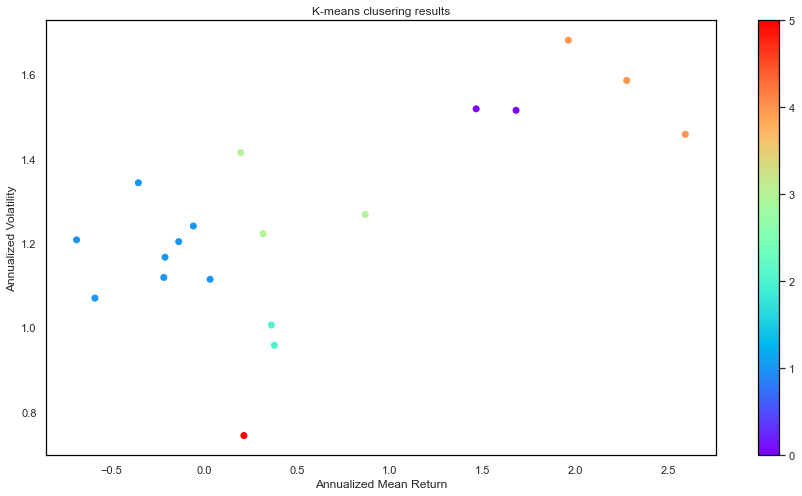

In [307]:
#centroids[:,0]
#centroids[:,:1]
plt.figure(figsize=(15,8))
sns.set(rc={'axes.facecolor':'white','axes.edgecolor':'black'})
#plt.scatter(centroids[:,0],centroids[:,1],marker='*',linewidth=4)
#plt.scatter(X.iloc[:,0],X.iloc[:,1],c=cluster_labels1,cmap ="rainbow")
plt.scatter(data.iloc[:,0],data.iloc[:,1],c=cluster_labels1,cmap ="rainbow")
plt.colorbar()
plt.grid(True)
plt.title('K-means clusering results')
plt.xlabel('Annualized Mean Return')
plt.ylabel('Annualized Volatility')

In [308]:
clustered_series1 = pd.Series(index= X.index, data= k_means.labels_)

In [309]:
clustered_series1[clustered_series1==1]

UNI     1
COMP    1
DOGE    1
XMR     1
LINK    1
BCH     1
XLM     1
LTC     1
dtype: int32

In [310]:
clustered_series1.value_counts()

1    8
3    3
4    3
0    2
2    2
5    1
dtype: int64

In [311]:
#plt.barh(clustered_series.value_counts(), width=range(0,len(clustered_series)))

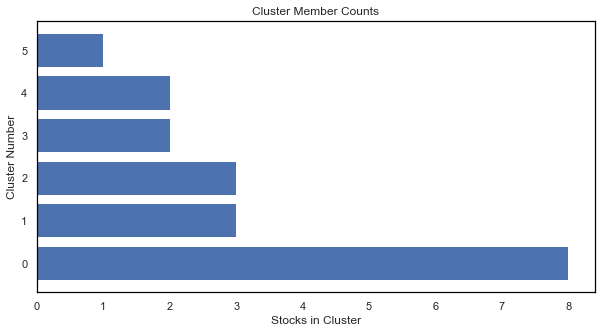

In [312]:
#showing number of stocks in each cluster
#sns.set(rc={'axes.facecolor':'white','axes.edgecolor':'black'})
clustered_series = pd.Series(index=X.index, data=k_means.labels_)

plt.figure(figsize=(10,5))
plt.barh(range(len(clustered_series1.value_counts())),clustered_series1.value_counts())
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number')
plt.show()

## Agglomerative clustering

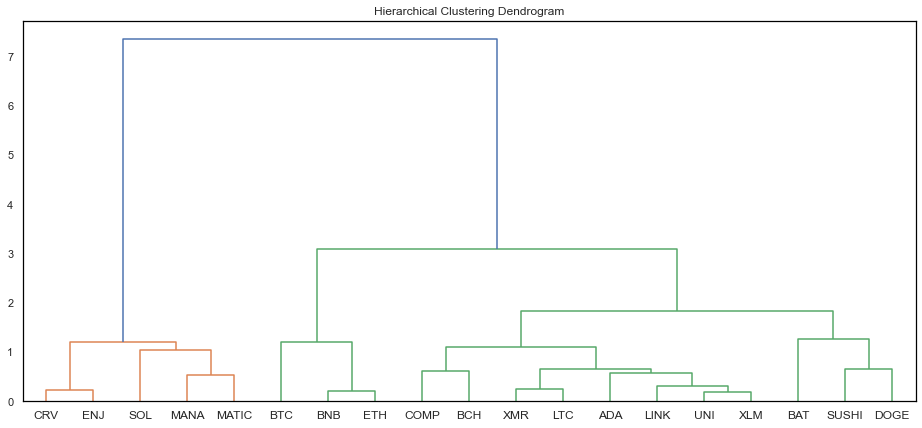

In [313]:
from scipy.cluster.hierarchy import dendrogram, linkage, ward

def plot_dendrogram(Y,model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    '''
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    '''
    linkage_matrix=linkage(X, method='ward')
    # Plot the corresponding dendrogram
    plt.figure(figsize=(16,7))
    plt.title("Hierarchical Clustering Dendrogram")
    dendrogram(linkage_matrix,labels = Y.index, **kwargs)
    return linkage_matrix


#iris = load_iris()
#X = iris.data
#Y=[[12,13],[15,25],[17,30]]
#Y=[[12,13,19],[15,25,17],[21,20,16],[12,78,1000]]
# setting distance_threshold=0 ensures we compute the full tree.
agglomerative = AgglomerativeClustering(n_clusters=None,distance_threshold=0)

agglomerative = agglomerative.fit(X)
# plot the top three levels of the dendrogram
linkage_matrix=plot_dendrogram(X,agglomerative, truncate_mode="level", p=30)
sns.set(rc={'axes.facecolor':'white','axes.edgecolor':'black'})
#plt.xlabel("Number of points in node (or index of point if no parenthesis).")

In [314]:
distance_threshold = 1.5
clusters = fcluster(linkage_matrix, distance_threshold, criterion='distance')
#The fcluster() method forms flat clusters from the hierarchical clustering. 
#This hierarchical clustering is defined by the given linkage matrix, identifying a link between clustered classes.
chosen_clusters = pd.Series(data=clusters,index= X.index)
np.sort(chosen_clusters.unique())

array([1, 2, 3, 4])

In [315]:
n_clusters2=6
agglomerative= AgglomerativeClustering(n_clusters=n_clusters2, affinity = 'euclidean', linkage = 'ward')
cluster_labels2 = agglomerative.fit_predict(X)

In [316]:
clustered_series2 = pd.Series(index= X.index, data= cluster_labels2)
np.sort(clustered_series2.unique())

array([0, 1, 2, 3, 4, 5], dtype=int64)

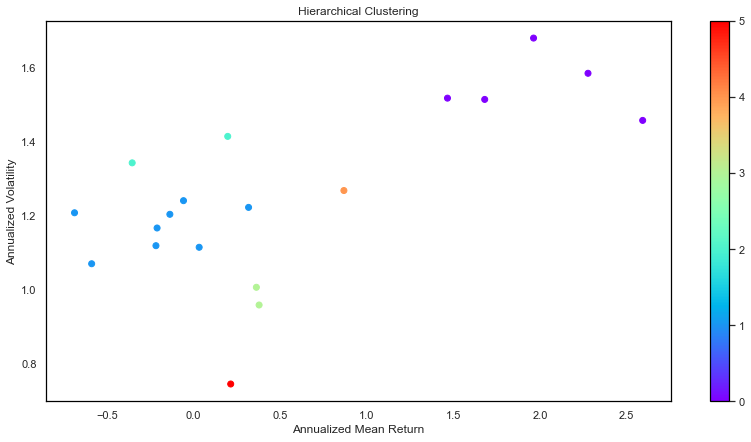

In [317]:
plt.figure(figsize=(14,7))
sns.set(rc={'axes.facecolor':'white','axes.edgecolor':'black'})
#plt.scatter(X.iloc[:,0],X.iloc[:,1], c =cluster_labels2,cmap='rainbow')
plt.scatter(data.iloc[:,0],data.iloc[:,1], c =cluster_labels2,cmap='rainbow')
plt.title('Hierarchical Clustering')
plt.xlabel('Annualized Mean Return')
plt.ylabel('Annualized Volatility')
plt.colorbar()

## Affinity Propagation

In [318]:
for i in tqdm(range(5,35)):
    affine = AffinityPropagation(random_state=seed,damping=0.5,convergence_iter=i,verbose=True)
    affine.fit(X)
    silhouette= metrics.silhouette_score(X,affine.predict(X),random_state=10)
    print(">> Silhouette Score at {0} is {1}% ".format(i,np.round(silhouette*100,3)))
    

 37%|█████████████████████████████▋                                                   | 11/30 [00:00<00:00, 105.89it/s]

Converged after 11 iterations.
>> Silhouette Score at 5 is 52.082% 
Converged after 12 iterations.
>> Silhouette Score at 6 is 52.082% 
Converged after 13 iterations.
>> Silhouette Score at 7 is 52.082% 
Converged after 14 iterations.
>> Silhouette Score at 8 is 52.082% 
Converged after 15 iterations.
>> Silhouette Score at 9 is 52.082% 
Converged after 16 iterations.
>> Silhouette Score at 10 is 52.082% 
Converged after 17 iterations.
>> Silhouette Score at 11 is 52.082% 
Converged after 18 iterations.
>> Silhouette Score at 12 is 52.082% 
Converged after 19 iterations.
>> Silhouette Score at 13 is 52.082% 
Converged after 20 iterations.
>> Silhouette Score at 14 is 52.082% 
Converged after 21 iterations.
>> Silhouette Score at 15 is 52.082% 
Converged after 22 iterations.
>> Silhouette Score at 16 is 52.082% 
Converged after 23 iterations.
>> Silhouette Score at 17 is 52.082% 
Converged after 24 iterations.
>> Silhouette Score at 18 is 52.082% 
Converged after 25 iterations.
>> Silho

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 114.83it/s]

>> Silhouette Score at 30 is 52.082% 
Converged after 37 iterations.
>> Silhouette Score at 31 is 52.082% 
Converged after 38 iterations.
>> Silhouette Score at 32 is 52.082% 
Converged after 39 iterations.
>> Silhouette Score at 33 is 52.082% 
Converged after 40 iterations.
>> Silhouette Score at 34 is 52.082% 


In [319]:
#convergence_iter is max till 10
affinity = AffinityPropagation(random_state=seed,damping=0.5,convergence_iter=10)
affinity2 = AffinityPropagation(random_state=seed,damping=0.5,convergence_iter=11)
affinity.fit(X)
affinity2.fit(X)
#requires no cluster value.

AffinityPropagation(convergence_iter=11, random_state=42)

In [320]:
cluster_labels3_1 = affinity.predict(X)  #With 10 iteration
cluster_labels3_2 = affinity2.predict(X)  #With 11 iteration
print(np.unique(cluster_labels3_1))
print(np.unique(cluster_labels3_2))

[0 1 2]
[0 1 2]


Text(19.0, 0.5, 'Annualized Volatility')

<Figure size 1008x504 with 0 Axes>

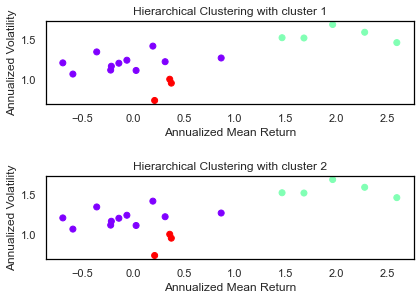

In [321]:
plt.figure(figsize=(14,7))
fig,ax= plt.subplots(2,1)
fig.tight_layout(h_pad=4)
sns.set(rc={'axes.facecolor':'white','axes.edgecolor':'black'})
#plt.scatter(X.iloc[:,0],X.iloc[:,1], c =cluster_labels2,cmap='rainbow')
ax[0].scatter(data.iloc[:,0],data.iloc[:,1], c =cluster_labels3_1,cmap='rainbow')
ax[1].scatter(data.iloc[:,0],data.iloc[:,1], c =cluster_labels3_2,cmap='rainbow')
ax[0].set_title('Hierarchical Clustering with cluster 1')
ax[1].set_title('Hierarchical Clustering with cluster 2')
ax[0].set_xlabel('Annualized Mean Return')
ax[1].set_xlabel('Annualized Mean Return')
ax[0].set_ylabel('Annualized Volatility')
ax[1].set_ylabel('Annualized Volatility')
#ax[0].set_colorbar()

## Collectively plotting the results

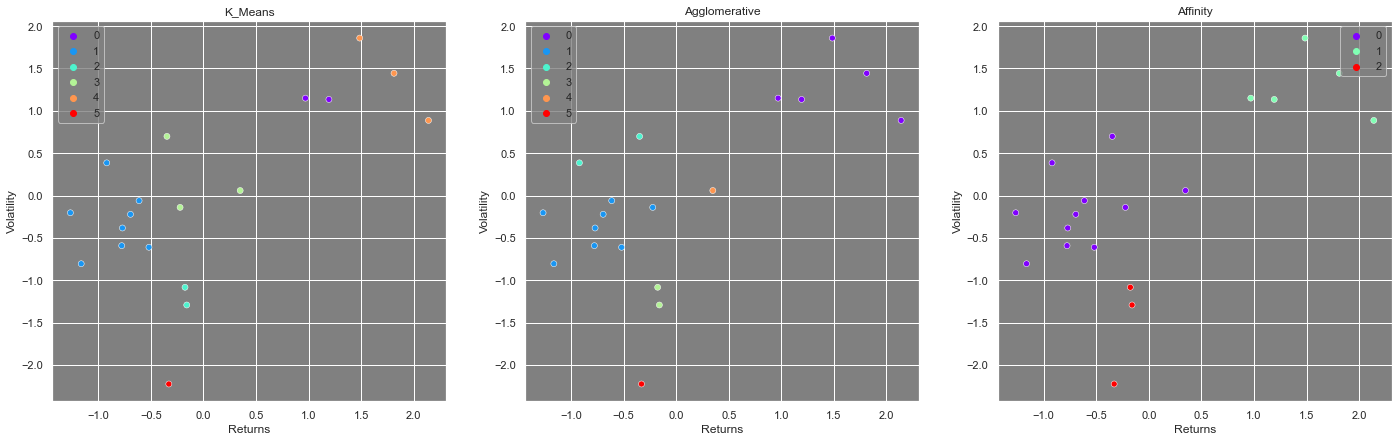

In [323]:
#Normalised Graphs
plt.figure(figsize=(24,7))
sns.set(rc={'axes.facecolor':'grey'})
i=1
for c in [[cluster_labels1, 'K_Means'],[cluster_labels2,'Agglomerative'],[cluster_labels3_1,'Affinity']]:
    plt.subplot(1,3,i)
    i+=1
    sns.scatterplot(X.iloc[:,0],X.iloc[:,1], hue =c[0],palette='rainbow')
    plt.title(c[1])

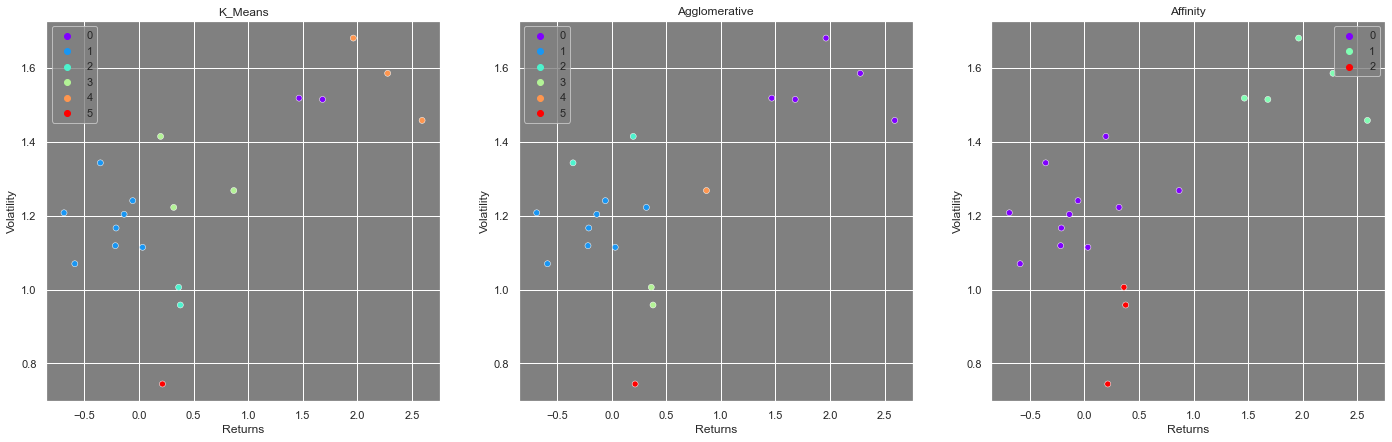

In [324]:
#Denormalised Graphs
plt.figure(figsize=(24,7))
sns.set(rc={'axes.facecolor':'grey'})
i=1
for c in [[cluster_labels1, 'K_Means'],[cluster_labels2,'Agglomerative'],[cluster_labels3_1,'Affinity']]:
    plt.subplot(1,3,i)
    i+=1
    sns.scatterplot(data.iloc[:,0],data.iloc[:,1], hue =c[0],palette='rainbow')
    plt.title(c[1])

## Selecting best model

In [480]:
print("KNN: {0}".format(metrics.silhouette_score(X, cluster_labels1,metric='euclidean',random_state=seed)))
print("Agglomerative: {0}".format(metrics.silhouette_score(X, cluster_labels2,metric='euclidean',random_state=seed)))
print("Affinity Propagation 1: {0}".format(metrics.silhouette_score(X, cluster_labels3_1,metric='euclidean',random_state=seed)))
print("Affinity Propagation 2: {0}".format(metrics.silhouette_score(X, cluster_labels3_2,metric='euclidean',random_state=seed)))

KNN: 0.36118097825674683
Agglomerative: 0.37855912592175744
Affinity Propagation 1: 0.5208157797324696
Affinity Propagation 2: 0.5208157797324696


In [337]:
cluster_labels3_1

array([2, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 2],
      dtype=int64)

In [481]:
#pwd

In [328]:
clustered_series= pd.Series(index=X.index, data= cluster_labels3_1)
counts= clustered_series.value_counts()
#cluster_vis = list

In [329]:
(counts[0])

11

In [330]:
clustered_series[clustered_series==1].index


Index(['CRV', 'SOL', 'MANA', 'MATIC', 'ENJ'], dtype='object')

In [331]:
len(np.unique(cluster_labels3_1))

3

In [332]:
plt.figure(figsize=(14,7))
cluster_list=[]
da1_pct=da1.pct_change(periods=24*12)

for i in range(0,len(np.unique(cluster_labels3_1))):
    if(counts[i]>1):
        cluster_list.append(clustered_series[clustered_series==i].index)
        
        
        
        
    
    

<Figure size 1008x504 with 0 Axes>

<AxesSubplot:xlabel='Observation Time', ylabel='Price'>

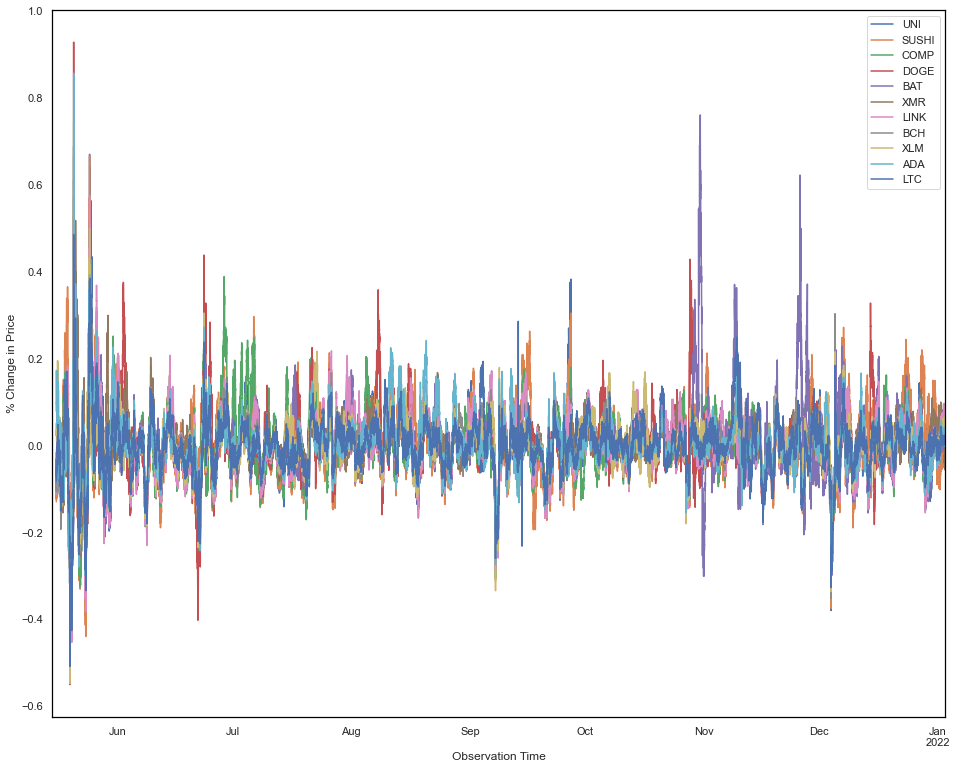

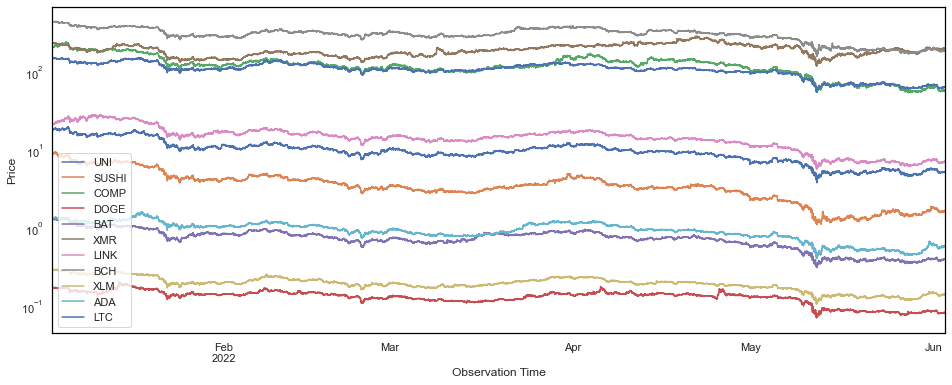

In [457]:
sns.set(rc={'axes.facecolor':'white','axes.edgecolor':'black'})
da1_pct[cluster_list[0]].plot(figsize=(16,13),xlabel= 'Observation Time',ylabel= '% Change in Price')
da1[cluster_list[0]].plot(figsize=(16,6),logy=True,secondary_y='SOL',grid=True,xlabel='Observation Time',ylabel= 'Price')

<AxesSubplot:xlabel='Observation Time', ylabel='Log Price'>

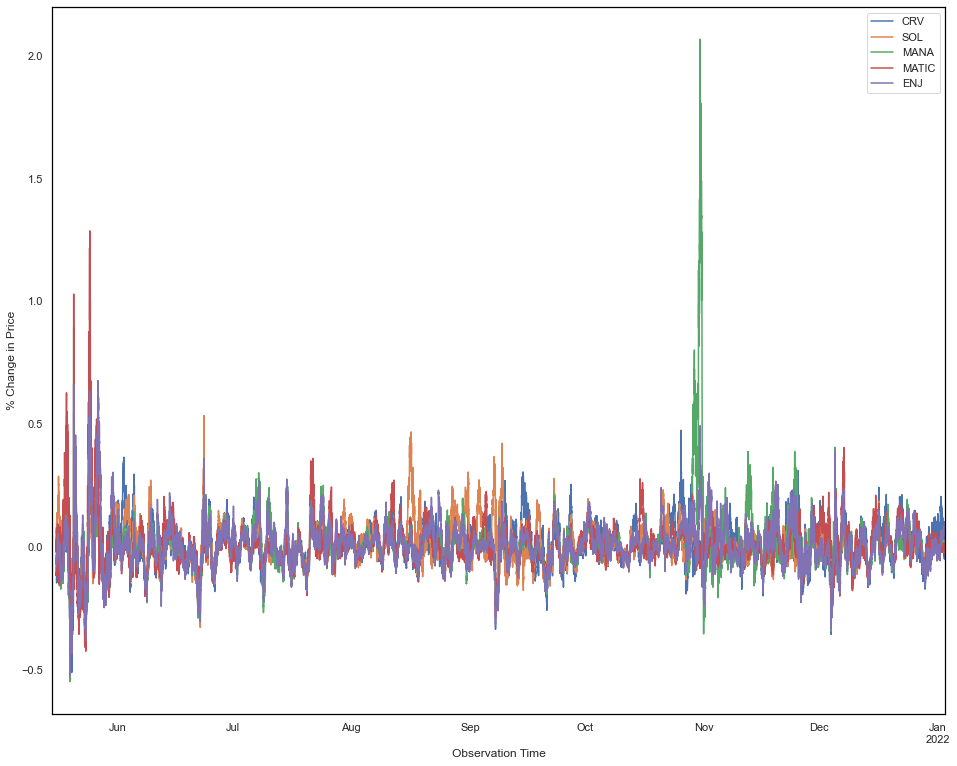

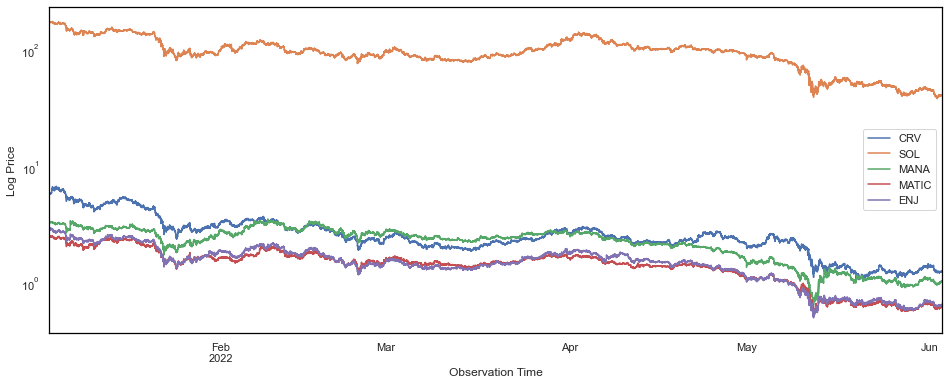

In [455]:
da1_pct[cluster_list[1]].plot(figsize=(16,13),xlabel= 'Observation Time',ylabel= '% Change in Price')
da1[cluster_list[1]].plot(figsize=(16,6),logy=True,secondary_y=['COMP','BCH','LTC'],xlabel='Observation Time',ylabel= 'Log Price')
#da1[cluster_list[1]].plot(figsize=(16,6),subplots=[('COMP', 'BTC'), ('LTC', 'DOGE')] )

<AxesSubplot:xlabel='Observation Time', ylabel='Log Price'>

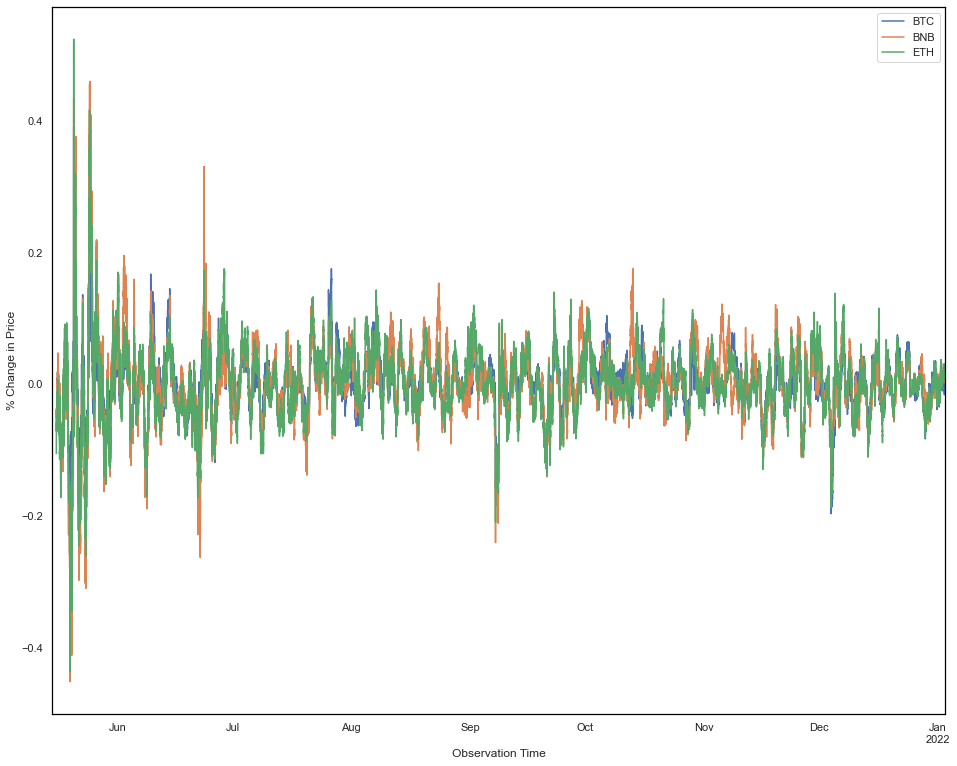

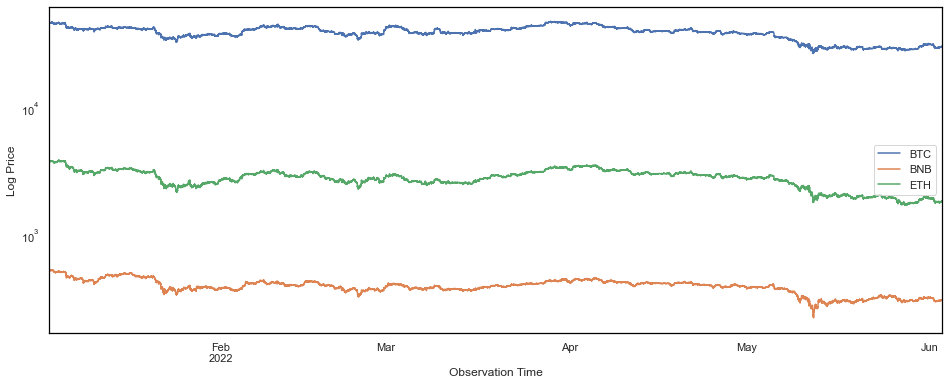

In [456]:
da1_pct[cluster_list[2]].plot(figsize=(16,13),xlabel= 'Observation Time',ylabel= '% Change in Price')
da1[cluster_list[2]].plot(figsize=(16,6),grid=True,logy=True,xlabel='Observation Time',ylabel= 'Log Price')

In [473]:
cluster_list[0]
#Pairs has been segregated based on volatility and mean returns.

Index(['UNI', 'SUSHI', 'COMP', 'DOGE', 'BAT', 'XMR', 'LINK', 'BCH', 'XLM',
       'ADA', 'LTC'],
      dtype='object')